In [1]:
#Importação das bibliotecas necessárias
import pandas as pd
import numpy as np

import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from pickle import dump, load

In [2]:
#Ignorar futuros warnings. Vale ressaltar que eu já rodei sem a presença dessa linha e nenhum warning afeta os resultados
warnings.filterwarnings('ignore')

In [3]:
#Importando o conjunto de dados
df = pd.read_json('teste.json')

In [4]:
ordens_coluna = ['home_name', 'away_name', 'home_score', 'away_score', 'final_result',
       'time', 'home_pos', 'away_pos', 'round', 'home_last5all_home',
       'home_last5all_home_win', 'home_last5all_home_draw',
       'home_last5all_home_lose', 'away_last5all_away',
       'away_last5all_away_win', 'away_last5all_away_draw',
       'away_last5all_away_lose', 'last5all_home_away_dif', 'fifa_home_ova',
       'fifa_home_att', 'fifa_home_mid', 'fifa_home_def', 'fifa_away_ova',
       'fifa_away_att', 'fifa_away_mid', 'fifa_away_def', 'elo_home_score',
       'elo_away_score', 'tfm_value_home', 'tfm_value_away']

In [5]:
#Alterando a ordem de colunas do df
df = df[ordens_coluna]

<h2>Análise Exploratória</h2>
<h3>Hipótese</h3>
1 - O elenco mais caro ganha mais os jogos (final_result)?<br/>

In [6]:
df.head()

,home_name,away_name,home_score,away_score,final_result,time,home_pos,away_pos,round,home_last5all_home,...,fifa_home_mid,fifa_home_def,fifa_away_ova,fifa_away_att,fifa_away_mid,fifa_away_def,elo_home_score,elo_away_score,tfm_value_home,tfm_value_away
0,FC Porto,Nacional,3,1,H,1546895700,1,11,16,9,...,81,80,70,70,70,69,1813.906738,1392.986084,2.779800e+08,9450000.0
1,Tenerife,Elche,2,1,H,1546632000,18,15,20,2,...,71,69,67,69,67,67,1513.179932,1475.512939,1.090000e+07,9600000.0
10,Man City,Everton,3,1,H,1544877000,2,7,17,16,...,88,83,79,79,80,79,1986.672974,1699.472778,1.090000e+09,426000000.0
100,Braga,FC Porto,0,1,A,1503861300,6,3,4,3,...,75,74,79,78,79,79,1562.021240,1745.115723,5.740000e+07,177650000.0
1000,Red Star FC 93,Strasbourg,1,1,D,1487358000,16,6,26,0,...,66,67,66,68,67,66,1407.163086,1422.037231,1.210000e+07,9850000.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5163 entries, 0 to 999
Data columns (total 30 columns):
home_name                  5163 non-null object
away_name                  5163 non-null object
home_score                 5163 non-null int64
away_score                 5163 non-null int64
final_result               5163 non-null object
time                       5163 non-null int64
home_pos                   5163 non-null int64
away_pos                   5163 non-null int64
round                      5163 non-null int64
home_last5all_home         5163 non-null int64
home_last5all_home_win     5163 non-null int64
home_last5all_home_draw    5163 non-null int64
home_last5all_home_lose    5163 non-null int64
away_last5all_away         5163 non-null int64
away_last5all_away_win     5163 non-null int64
away_last5all_away_draw    5163 non-null int64
away_last5all_away_lose    5163 non-null int64
last5all_home_away_dif     5163 non-null int64
fifa_home_ova              5163 non-null int6

In [8]:
#Verificando se existe algum dado ausente
df.isnull().sum().sort_values(ascending=False)

tfm_value_away             0
tfm_value_home             0
away_name                  0
home_score                 0
away_score                 0
final_result               0
time                       0
home_pos                   0
away_pos                   0
round                      0
home_last5all_home         0
home_last5all_home_win     0
home_last5all_home_draw    0
home_last5all_home_lose    0
away_last5all_away         0
away_last5all_away_win     0
away_last5all_away_draw    0
away_last5all_away_lose    0
last5all_home_away_dif     0
fifa_home_ova              0
fifa_home_att              0
fifa_home_mid              0
fifa_home_def              0
fifa_away_ova              0
fifa_away_att              0
fifa_away_mid              0
fifa_away_def              0
elo_home_score             0
elo_away_score             0
home_name                  0
dtype: int64

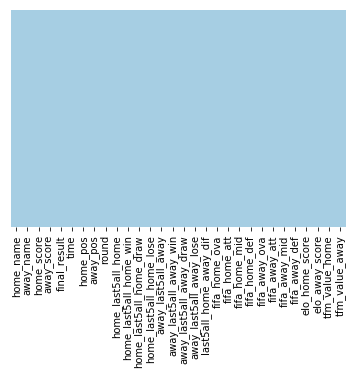

In [9]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='Paired')

In [10]:
#Verificando quantos exemplos há no dataset da classe alvo
df['final_result'].value_counts()

H    2306
A    1500
D    1357
Name: final_result, dtype: int64

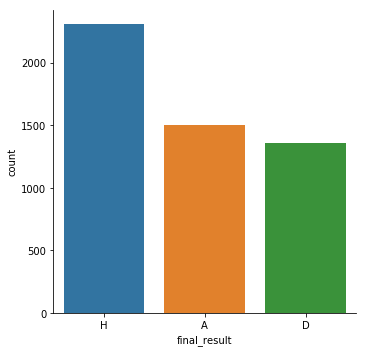

In [11]:
sns.catplot('final_result',data=df, kind='count')

In [12]:
ds1 = df[(df['tfm_value_home'] > df['tfm_value_away'])]
ds1 = ds1[ds1['final_result']=="H"]
ds1.shape

(1472, 30)

In [13]:
ds2 = df[(df['tfm_value_home'] < df['tfm_value_away'])]
ds2 = ds2[ds2['final_result']=="A"]
ds2.shape

(1027, 30)

In [14]:
ds3 = df[(df['tfm_value_home'] > df['tfm_value_away'])]
ds3 = ds3[ds3['final_result']=="A"]
ds3.shape

(470, 30)

In [15]:
ds4 = df[(df['tfm_value_home'] < df['tfm_value_away'])]
ds4 = ds4[ds4['final_result']=="H"]
ds4.shape

(831, 30)

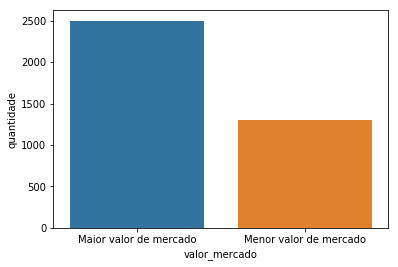

In [16]:
conj = {'valor_mercado': ['Maior valor de mercado', 'Menor valor de mercado'], 'quantidade': [ds1.shape[0] + ds2.shape[0], ds3.shape[0] + ds4.shape[0]]}
dfH1 = pd.DataFrame(conj, columns=['valor_mercado', 'quantidade'])
sns.barplot(x='valor_mercado', y='quantidade', data=dfH1)

<h2>Criação do Modelo</h2>

Primeira Versão de Features<br/>

In [17]:
X = df.drop(['home_name', 'away_name', 'home_score', 'away_score', 'time', 'final_result'], inplace=False, axis=1)
y = df['final_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

<h5>Gradient Boosting</h5>

In [18]:
pipe = Pipeline(steps= [("standardscaler", StandardScaler()),
                        ("gradientboostingclassifier", GradientBoostingClassifier())
                       ])

In [19]:
param_grid_GB = {
    "gradientboostingclassifier__learning_rate": [0.0001, 0.1, 0.2],
    "gradientboostingclassifier__max_depth":[3, 5],
    "gradientboostingclassifier__max_features":["log2","sqrt"],
    "gradientboostingclassifier__n_estimators":[10, 100, 300]
    }

In [20]:
grid = GridSearchCV(pipe, param_grid=param_grid_GB, scoring="accuracy", iid=False, refit=True, cv=5, return_train_score=False)

In [21]:
grid.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
   ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'gradientboostingclassifier__learning_rate': [0.0001, 0.1, 0.2], 'gradientboostingclassifier__max_depth': [3, 5], 'gradientboostingclassifier__max_features': ['log2', 'sqrt'], 'gradientboostingclassifier__n_estimators': [10, 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [22]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
 ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
{'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__n_estimators': 10}
0.5097796075293725


<h5>Random Forest</h5>

In [23]:
pipeRF = Pipeline(steps= [("standardscaler", StandardScaler()),
                        ("randomforestclassifier", RandomForestClassifier())
                       ])

In [24]:
param_grid_RF = { 
    'randomforestclassifier__n_estimators': [10, 100, 500],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__max_depth' : [4, 8],
    'randomforestclassifier__min_samples_split': [2, 8],
    'randomforestclassifier__min_samples_leaf': [1, 5]
}

In [25]:
gridRF = GridSearchCV(pipeRF, param_grid=param_grid_RF, scoring='accuracy', iid=False, refit=True, cv=5, return_train_score=False)

In [26]:
gridRF.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'randomforestclassifier__n_estimators': [10, 100, 500], 'randomforestclassifier__max_features': ['sqrt', 'log2'], 'randomforestclassifier__max_depth': [4, 8], 'randomforestclassifier__min_samples_split': [2, 8], 'randomforestclassifier__min_samples_leaf': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [27]:
gridRF.scorer_, gridRF.best_estimator_, gridRF.best_params_, gridRF.best_score_

(make_scorer(accuracy_score), Pipeline(memory=None,
      steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=8, max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_im...obs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))]), {'randomforestclassifier__max_depth': 8,
  'randomforestclassifier__max_features': 'log2',
  'randomforestclassifier__min_samples_leaf': 5,
  'randomforestclassifier__min_samples_split': 2,
  'randomforestclassifier__n_estimators': 500}, 0.5136536997218141)

In [28]:
standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

In [29]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
predRF = rf.predict(X_test_std)

In [31]:
print(confusion_matrix(y_test, predRF))
print(classification_report(y_test, predRF))
print(accuracy_score(y_test, predRF))

[[166  47 251]
 [ 95  43 279]
 [ 84  53 531]]
              precision    recall  f1-score   support

           A       0.48      0.36      0.41       464
           D       0.30      0.10      0.15       417
           H       0.50      0.79      0.61       668

   micro avg       0.48      0.48      0.48      1549
   macro avg       0.43      0.42      0.39      1549
weighted avg       0.44      0.48      0.43      1549

0.4777275661717237


In [32]:
# Verifica a importância de cada variável no modelo
fName = pd.DataFrame(X.columns, columns=['Feature'])
fImp = pd.DataFrame(rf.feature_importances_, columns=['Importance'])
dfFI = pd.concat([fName, fImp], axis=1)

In [33]:
dfFI.sort_values('Importance', ascending=False)

,Feature,Importance
21,elo_away_score,0.074450
20,elo_home_score,0.071911
23,tfm_value_away,0.065403
22,tfm_value_home,0.065318
2,round,0.056260
0,home_pos,0.049481
1,away_pos,0.048713
11,last5all_home_away_dif,0.047333
7,away_last5all_away,0.043882
3,home_last5all_home,0.043132


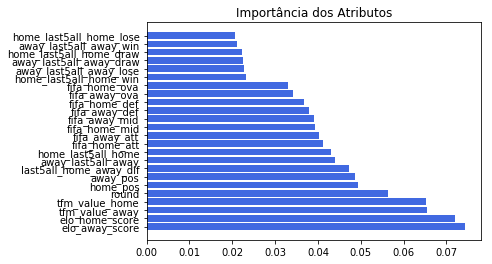

In [34]:
dfIF = dfFI.sort_values('Importance', ascending=False)

fIF = dfIF['Feature']
iIF = dfIF['Importance']

plt.title('Importância dos Atributos')
plt.barh(range(len(fIF)), iIF, color='royalblue', align='center')
plt.yticks(range(len(fIF)), fIF)
plt.show()

In [35]:
features = list(dfFI[dfFI['Importance'] < 0.045]['Feature'])
features.append('home_name')
features.append('away_name')
features.append('home_score')
features.append('away_score')
features.append('time')
features.append('final_result')

<h6>Pré-processamento</h6>
Redução de dimensionalidade, com base nas features mais importantes, escolhido pelo Random Forest<br/>
Criação de novas dimensões para verificar se há uma melhora no aprendizado

In [36]:
X = df.drop(features, inplace=False, axis=1)
X['score_elo_home_away_dif'] = X['elo_home_score'] - X['elo_away_score']
X['tfm_value_home_away_dif'] = X['tfm_value_home'] - X['tfm_value_away']
y = df['final_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [37]:
X.columns

Index(['home_pos', 'away_pos', 'round', 'last5all_home_away_dif',
       'elo_home_score', 'elo_away_score', 'tfm_value_home', 'tfm_value_away',
       'score_elo_home_away_dif', 'tfm_value_home_away_dif'],
      dtype='object')

In [38]:
grid.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
   ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'gradientboostingclassifier__learning_rate': [0.0001, 0.1, 0.2], 'gradientboostingclassifier__max_depth': [3, 5], 'gradientboostingclassifier__max_features': ['log2', 'sqrt'], 'gradientboostingclassifier__n_estimators': [10, 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [39]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features='log2', max_leaf_nodes=None,
 ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
{'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__max_features': 'log2', 'gradientboostingclassifier__n_estimators': 10}
0.5159781561984855


<h6>Gravar o modelo criado em disco</h6>

In [40]:
# Salva o modelo em disco
filename = 'modeloGB.sav' 
dump(grid, open(filename, 'wb'))

<h6>SVM</h6>

In [41]:
svc = SVC(C=5.0, kernel='rbf', degree=5, probability=True)

In [42]:
svc.fit(X_train_std, y_train)

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [43]:
pred = svc.predict_proba(X_test_std)

In [44]:
pred[:]

array([[0.29881325, 0.25529595, 0.4458908 ],
       [0.29330926, 0.26481083, 0.4418799 ],
       [0.29584689, 0.25538871, 0.4487644 ],
       ...,
       [0.28403515, 0.26098479, 0.45498006],
       [0.28884843, 0.26740694, 0.44374463],
       [0.2967101 , 0.26045221, 0.44283769]])

In [45]:
svc.classes_

array(['A', 'D', 'H'], dtype=object)

<h2>Conclusão</h2>
* O modelo não conseguiu generalizar os dados (Overfitting)
* Não consegue encontrar um padrão nos exemplos de empate 
* Possíveis soluções:
    + Estudar mais o cenário e regra de negócio para criar atributos relevantes
    + Capturar mais exemplos de partidas de futebol (principalmente os empates)